#### Computational Modeling of Cognition and Behavior

# 2 From Words to Models
## Building a Toolkit

***

## 2.1 Response Times in Speeded-Choice Tasks

***

<br>

"Choice rection time" task (Smith and Vickers 1998)

<br>

Can be approached using a "random walk model":

<br>

Simple model assumptions:

- Evidence for a decision is built up gradually.

- Evidence is sampled at discrete time steps.

- Sampling starts with 0 evidence


How the model works:

- Magnitude of discrete nudges towards a decision reflects the information available at a single sample.

- Sampled evidence is summed accross time steps until a response threshold is reached.

- Sampling starts with 0 evidence and moves towards one of two thresholds, each representing a choice (left/righ for example).

Some conclusions:

- If the two thresholds are equidistant from 0, the reponse times should be equal.


Prediction of the model:

- Response time is dependent on evidence 

<br>

## 2.1 Response Times in Speeded-Choice Tasks

***
<br>

### 2.2.1 Getting started

<br>

### 2.2.2 The Random-Walk Model

<br>

First, a function is created to simulate a single trial, it takes the decision variable drift for a single trial and a threshold as it's inputs.

<br>


In [1]:
import numpy as np


def random_walk_trial(acc_drift_row, threshold):
    """
    Single trial for a random walk model of decision making.

    Parameters
    ----------
    acc_drift_row : numpy.ndarray
        A single row numpy array, containing a cumulative sum of random 
        increments.

    threshold : float
        The value of evidence at which a decision is made.

    Returns
    -------
    acc_drift_row : numpy.ndarray
        A single row numpy array, containing a cumulative sum of random 
        increments. Once a value reaches the threshold the trial is over
        and following values are set to NaN.

    trial_latency : int
        The index which a decision is made (the evidence crosses a 
        threshold). -1 if no decision is made.

    trial_response : int
        + 1 for decision made for upper threshold, -1 when decision made 
        for negative threshold, 0 for no decision made.
    """
    try:
        # look for the first index when the threshold is crossed
        trial_latency = np.where(np.abs(acc_drift_row) >= threshold)[0][0]
    # if the index is never crossed
    except IndexError:
        trial_latency = -1  # no latency
    if trial_latency == -1:
        trial_response = 0  # no response
    # if the index is crossed
    else:
        trial_response = np.sign(acc_drift_row[trial_latency])
        # After the decision is made the trial ends
        acc_drift_row[trial_latency + 1:] = np.NaN
    return acc_drift_row, trial_latency, trial_response

<br>

Then, a function is created to generate evidence, with a row for every trial. A third function runs the random walk model on every trial. Two dataframes are output. 'df_trial_data' gives a trial per row, containing the trial response and trail latency (time taken to make a decision). The second dataframe 'df_dv' contains the decision variable (dv) for every time point (rows) for every trial (columns). 

<br>

**Note**: Model is not an evidence accumulator model! Evidence fixes the centre of a distribution of drift.


In [2]:
import pandas as pd

def gen_drift(evidence, sd_rw, nreps, nsamples):
    """
    Generate random drift, of a decision variable dependent on evidence
    
     Parameters
    ----------
    evidence : float
        The evidence given by the stimuli. The drift of the decision 
        variable is defined by increments drawn from a random normal 
        distribution with this mean value.
        
    sd_rw : float
        The drift of the decision variable is defined by increments 
        drawn from a random normal distribution with this standard 
        deviation.
        
    nreps : int
        The number of trials.

    nsamples : int
        The length of each trial.

    Returns
    -------
    acc_drift : numpy.ndarray
        A 2d numpy array representing the drift of the decision variable. 
        Each row is a trial and each column is a sample (time point).
        """
    start_zero_drift = np.zeros((nreps, 1))
    rand_norm_incr = np.random.normal(loc=evidence,
                                      scale=sd_rw,
                                      size=[nreps, nsamples])
    drift_incr = np.concatenate((start_zero_drift, rand_norm_incr),
                                   axis=1)
    acc_drift = drift_incr.cumsum(axis=1)
    return acc_drift

def random_walk(nreps, threshold, acc_drift):
    """
    Random walk model of decision making.
    
    Parameters
    ----------
    nreps : int
        The number of trials.
        
    threshold : float
        The value of evidence at which a decision is made.
              
    acc_drift : numpy.ndarray
        A numpy array representing the drift of the decision variable.

    Returns
    -------
    df_dv : pandas.core.frame.DataFrame
        A DataFrame containing a column per trial, row per time point.
        Data represents the decision variable (internal evidence).
        
    df_trial_data : pandas.core.frame.DataFrame
        A DataFrame containing two columns trial_latency and
         trial_response. Note that the length of columns is n_reps.
    
    """
    # run the random walk function on every row of drift
    dv, trial_latency, trial_response = zip(*[random_walk_trial(acc_drift_row, threshold)
                                              for acc_drift_row
                                              in acc_drift])
    column_names = ["trial_" + str(trial_n + 1) for trial_n in np.arange(nreps)]
    dv_array = np.asarray(dv).T
    df_dv = pd.DataFrame(data=dv_array,
                         columns=column_names)
    df_trial_data = pd.DataFrame(data={'trial_latency': trial_latency,
                                       'trial_response': trial_response})
    return df_dv, df_trial_data

<br>

Then I set some specific values to variables and run a simulation.

<br>


In [3]:
from IPython.display import display

nreps = 10000
nsamples = 500
evidence = 0    # the amount of evidence, 0 gives a random decision 
sd_rw = 0.3     # standard deviation of the random walk 
threshold = 3

acc_drift = gen_drift(evidence,
                      sd_rw,
                      nreps,
                      nsamples)
df_dv, df_trials = random_walk(nreps,
                               threshold,
                               acc_drift)

evidence = 0.03  # the amount of evidence, 0.03 gives a decision to the above boundry

acc_drift = gen_drift(evidence,
                      sd_rw,
                      nreps,
                      nsamples)
df_dv_above, df_trials_above = random_walk(nreps,
                                           threshold,
                                           acc_drift)

display(df_dv)
display(df_trials)

,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10,...,trial_9991,trial_9992,trial_9993,trial_9994,trial_9995,trial_9996,trial_9997,trial_9998,trial_9999,trial_10000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.214068,-0.407924,-0.091714,-0.412214,0.166096,-0.021942,-0.097611,-0.351946,0.407145,0.129694,...,0.123642,0.377914,0.207648,-0.722748,0.134271,0.223427,0.670720,0.377053,0.097128,-0.009092
2,-0.391059,-0.765179,-0.310370,-0.172166,0.403066,0.419572,-0.367728,-0.043624,0.520421,0.934479,...,0.332599,0.339069,-0.147486,-0.772815,0.820084,0.125375,1.224111,0.927163,0.003803,0.245470
3,-0.356896,-0.650868,-0.056595,-0.302442,0.671086,0.042688,-0.666337,-0.406115,0.673674,1.279852,...,0.658326,0.311049,0.035297,-0.954495,0.610380,0.670466,1.351657,0.546793,0.262489,-0.102981
4,-0.955557,-0.772693,-0.267573,-0.716584,0.285227,0.210995,-1.004318,-0.612110,0.730261,1.479546,...,1.110730,0.666794,0.020091,-0.884267,0.575023,0.343985,1.467909,0.787290,0.638227,0.095040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,trial_latency,trial_response
0,202,1.0
1,110,1.0
2,91,-1.0
3,167,1.0
4,192,-1.0
...,...,...
9995,200,-1.0
9996,19,1.0
9997,42,1.0
9998,157,-1.0


<br>

From this point, it is simple to plot and visualise the decision variable for several trials.

<br>

### 2.2.3 Intuition vs. Computation: Exploring the Predictions of a Random Walk

Text(0.5, 0.95, 'Figure 1')

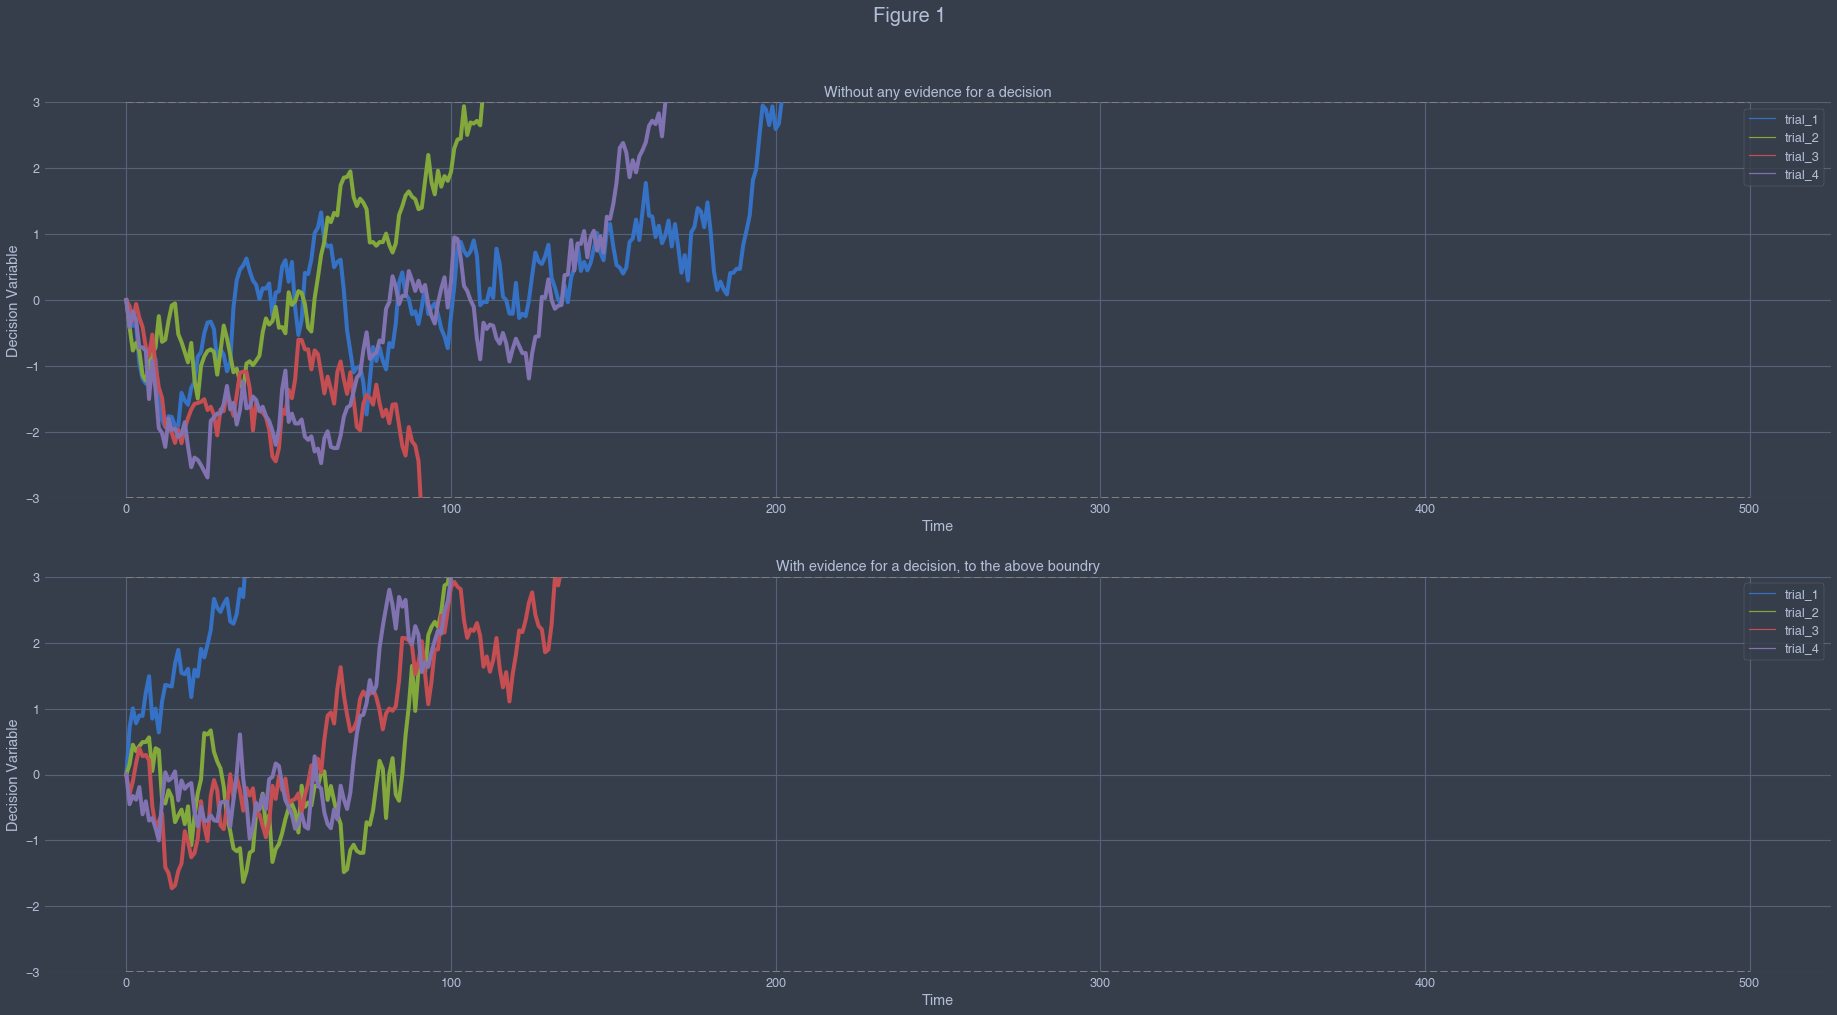

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('onedork',
             spines=False,
             figsize=(40, 20))

plt.subplot(2, 1, 1)
plt.xlabel('Time')
plt.ylabel('Decision Variable')
plt.title('Without any evidence for a decision')
plt.ylim(-3,3)
sns.lineplot(data=df_dv.iloc[:, 0:4],
             dashes=False,
             linewidth=4);
plt.plot([0, nsamples], [3, 3],
         linestyle='--',
         linewidth=2,
         c='grey');
plt.plot([0, nsamples], [-3, -3],
         linestyle='--',
         linewidth=2,
         c='grey');

plt.subplot(2, 1, 2)
plt.xlabel('Time')
plt.ylabel('Decision Variable')
plt.title('With evidence for a decision, to the above boundry')
plt.ylim(-3,3)
sns.lineplot(data=df_dv_above.iloc[:, 0:4],
             dashes=False,
             linewidth=4);
plt.plot([0, nsamples], [3, 3],
         linestyle='--',
         linewidth=2,
         c='grey');
plt.plot([0, nsamples], [-3, -3],
         linestyle='--',
         linewidth=2,
         c='grey');

txt = 'Figure 1'
plt.figtext(0.5, 0.95, txt, wrap=True, horizontalalignment='center', fontsize=20)

<br>

And view the distribution of latencies in a histogram, seperated by choice (high boundry, low boundry):

<br>

Text(0.5, 0.95, 'Figure 2')

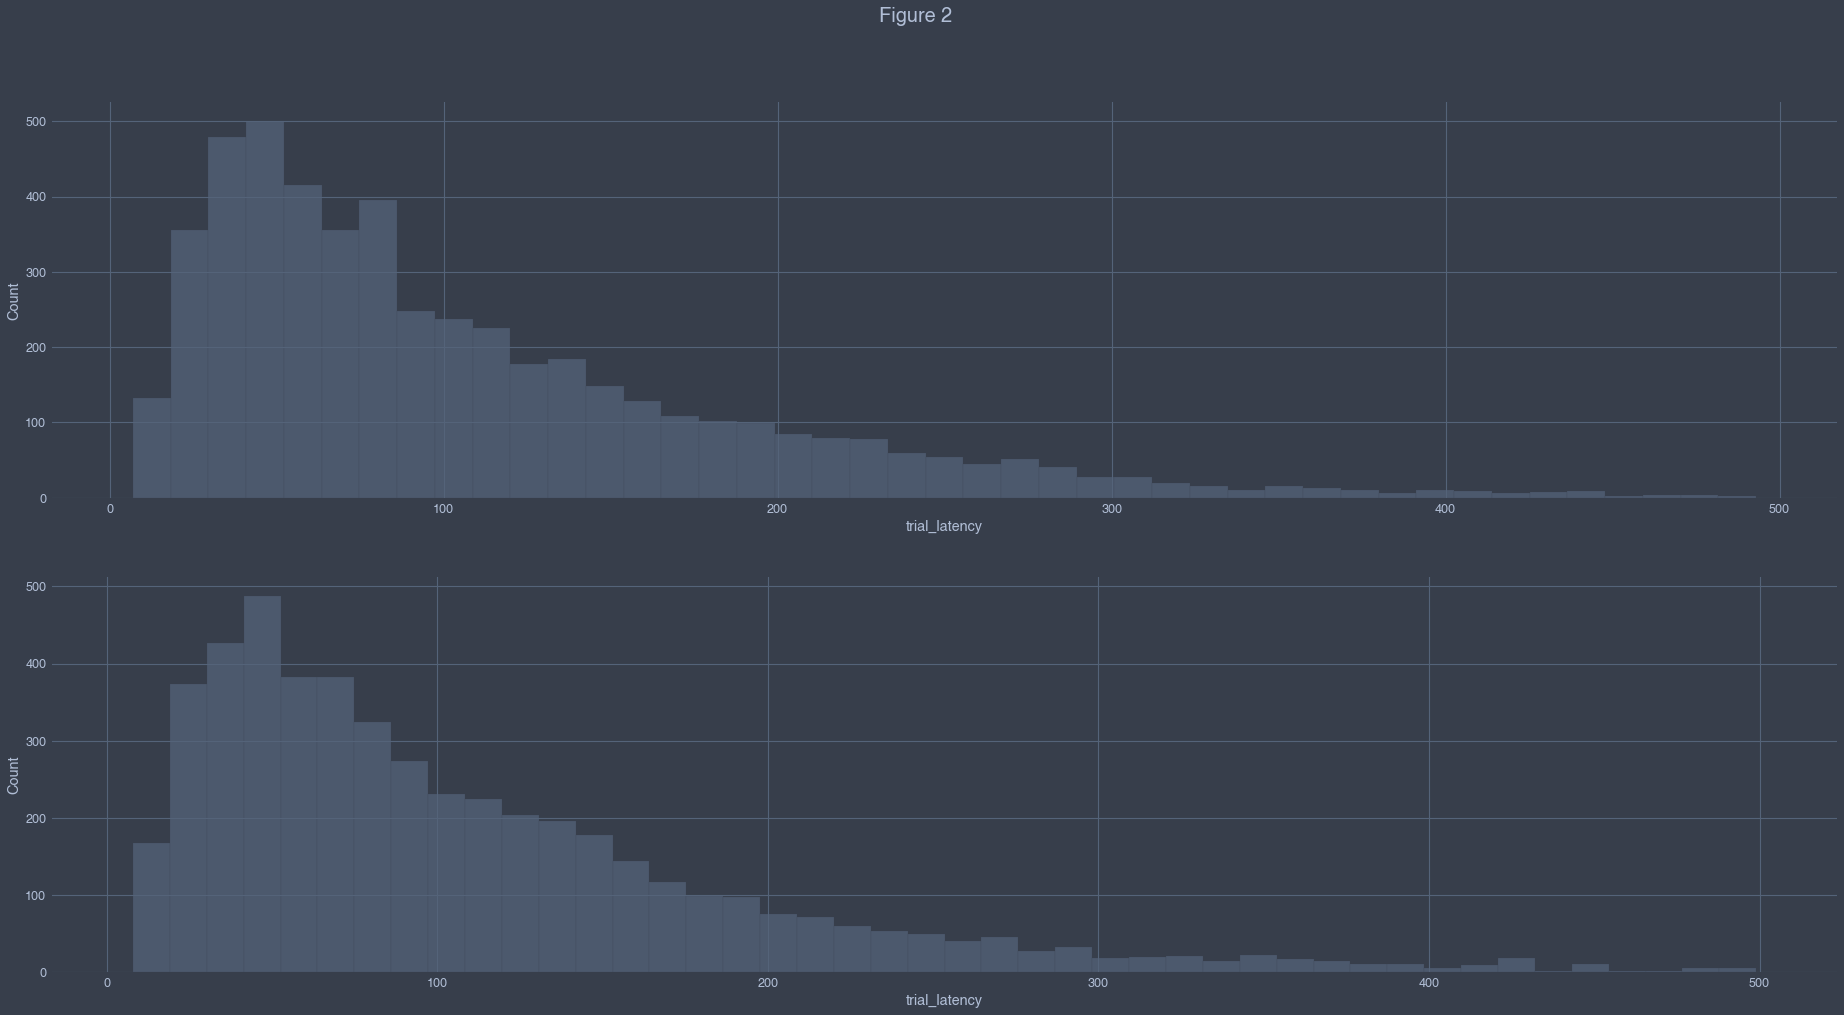

In [5]:
plt.subplot(2, 1, 1)
plt.ylabel('Count')
sns.histplot(df_trials.trial_latency[df_trials.trial_response == 1],  # high boundry
            kde=False);
plt.subplot(2, 1, 2)
plt.ylabel('Count')
sns.histplot(df_trials.trial_latency[df_trials.trial_response == -1],  # low boundry
            kde=False);

txt = 'Figure 2'
plt.figtext(0.5, 0.95, txt, wrap=True, horizontalalignment='center', fontsize=20)

<br> 

The same can be done for the example with evidence 0.03, drifting more to the above boundry

<br>



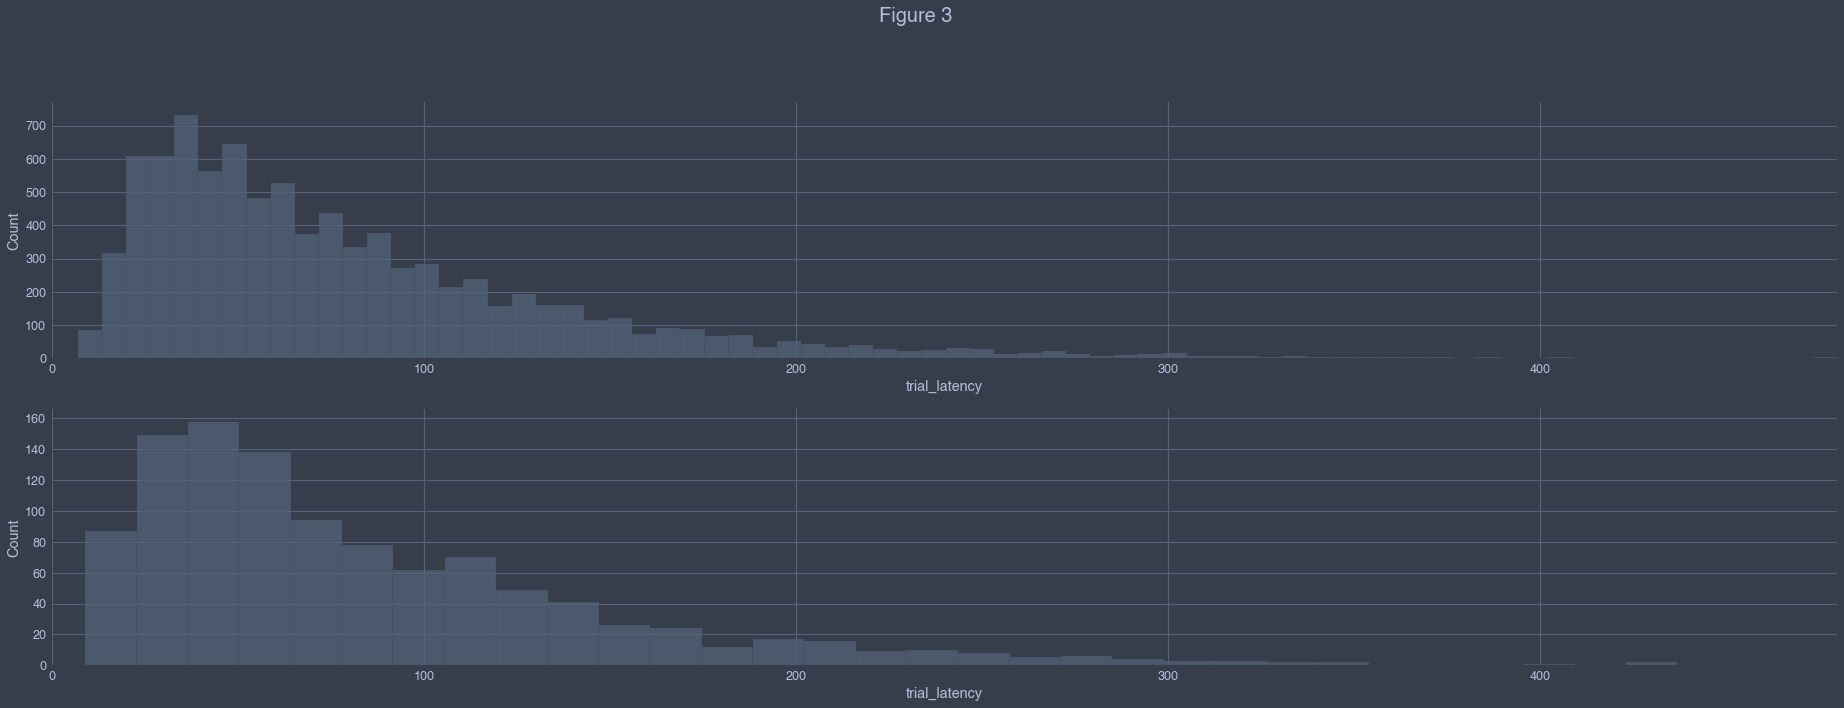

In [6]:
plt.subplot(3, 1, 1)
plt.ylabel('Count')
sns.histplot(df_trials_above.trial_latency[df_trials_above.trial_response == 1],  # high boundry
            kde=False);
plt.xlim(0, max(df_trials_above.trial_latency))

plt.subplot(3, 1, 2)
plt.ylabel('Count')
sns.histplot(df_trials_above.trial_latency[df_trials_above.trial_response == -1],  # low boundry
             kde=False);
plt.xlim(0, max(df_trials_above.trial_latency))

txt = 'Figure 3'
plt.figtext(0.5, 0.95, txt, wrap=True, horizontalalignment='center', fontsize=20);

<br>

Even though the counts are much lower for the non-evidenced choice, the distribution of the latencies is similar to the evidenced choice. The longer a trial goes on, the more likely it is to be drifted to the evidenced side. 


### 2.2.4 Trial-to-Trial Variability in the Random-Walk Model

<br>

Both the starting point of the decision variable and the drift can vary randomly trial to trial. Below, is a function to introduce noise to both the starting point and the drift.

In [7]:
def gen_drift_with_noise(evidence, sd_rw, nreps, nsamples, start_noise, evidence_noise):
    """
    Generate random drift, of a decision variable dependent on evidence. 
    Includes noise to the starting evidence and the standard deviation of the
    drift
    
    
    Parameters
    ----------
    evidence : float
        The evidence given by the stimuli. The drift of the decision 
        variable is defined by increments drawn from a random normal 
        distribution with this mean value.
        
    sd_rw : float
        The drift of the decision variable is defined by increments 
        drawn from a random normal distribution with this standard 
        deviation.
        
    nreps : int
        The number of trials.

    nsamples : int
        The length of each trial.
        
    start_noise : int
        The standard deviation of the noise on the starting point of the
        decision variable.
        
    evidence_noise : int

    Returns
    -------
    acc_drift : numpy.ndarray
        A 2d numpy array representing the drift of the decision variable. 
        Each row is a trial and each column is a sample (time point).
        """
    trial_start = np.random.normal(loc=0,
                                   scale=start_noise,
                                   size=[nreps, 1])
    drift_sd = np.random.normal(loc=sd_rw,
                                scale=evidence_noise,
                                size=[nreps, nsamples])
    rand_norm_incr = np.random.normal(loc=evidence,
                                      scale=drift_sd,
                                      size=[nreps, nsamples])
    drift_incr = np.concatenate((trial_start, rand_norm_incr),
                                axis=1)
    acc_drift = drift_incr.cumsum(axis=1)
    return acc_drift

<br>
Then run an example of each:
<br>


In [8]:
start_noise = 0.5
evidence_noise = 0

noisy_start_drift = gen_drift_with_noise(evidence,
                                         sd_rw,
                                         nreps,
                                         nsamples,
                                         start_noise,
                                         evidence_noise)
df_dv_above_noisy_start, df_trials_above_noisy_start = random_walk(nreps,
                                                                   threshold,
                                                                   noisy_start_drift)
start_noise = 0
evidence_noise = 0.05

noisy_evidence_drift = gen_drift_with_noise(evidence,
                                            sd_rw,
                                            nreps,
                                            nsamples,
                                            start_noise,
                                            evidence_noise)
df_dv_above_noisy_evidence, df_trials_above_noisy_evidence = random_walk(nreps,
                                                                         threshold,
                                                                         noisy_evidence_drift)

<br>
The function below plots both the decision variable over time and latency distributions, for both decisions, in a single function to simplify the plotting. 
<br>
<br>

In [9]:
def plot_random_walk_with_distribution(df_dv, df_trials, titles):
    """ 
    Create a figure with three subplots from DataFrames representing 
    a random walk model. The first shows a decision variable over time 
    for 5 trials. The second two show the distribution of decision time
    latencies for each decision.

    Parameters
    ----------
    df_dv : pandas.core.frame.DataFrame
        A DataFrame containing a column per trial, row per time point.
        Data represents the decision variable (internal evidence).

    df_trial_data : pandas.core.frame.DataFrame
        A DataFrame containing two columns trial_latency and
         trial_response. Note that the length of columns is n_reps.

    titles : dict
        Contains titles for each subfigure, inder the keys 'dv' (figure 1)
        dist_chose_above (figure 2), dist_chose_bellow (figure 3)

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object

    axes : tuple
        tuple of axis handles for each subfigure
    """
    fig = plt.figure()
    ax1 = plt.subplot(3, 1, 1)
    plt.xlabel('Time')
    plt.ylabel('Decision Variable')
    plt.title(titles['dv'], fontsize=18)
    plt.ylim(-3, 3)
    sns.lineplot(data=df_dv.iloc[:, 0:4],
                 dashes=False,
                 linewidth=4)
    ax1.plot([0, nsamples], [3, 3],
             linestyle='--',
             linewidth=2,
             c='grey')
    plt.plot([0, nsamples], [-3, -3],
             linestyle='--',
             linewidth=2,
             c='grey')

    ax2 = plt.subplot(3, 1, 2)
    plt.title(titles['dist_chose_above'], fontsize=18)
    plt.ylabel('Count')
    sns.histplot(df_trials.trial_latency[df_trials.trial_response == 1],  # high boundry
                 kde=False)
    plt.xlim(0, max(df_trials.trial_latency))

    ax3 = plt.subplot(3, 1, 3)
    plt.title(titles['dist_chose_below'], fontsize=18)
    plt.ylabel('Count')
    sns.histplot(df_trials.trial_latency[df_trials.trial_response == -1],  # low boundry
                 kde=False)
    plt.xlim(0, max(df_trials.trial_latency))

    fig.tight_layout(h_pad=2)
    axes = (ax1, ax2, ax3)
    return fig, axes

<br>

Now we can easily run our noisy examples. In this case there is a leftward shift of the distribution in error trials; trial latency is shorter. In many trials, crossing the boundry was possible because of the decision variable starting at a point below 0. 

<br>


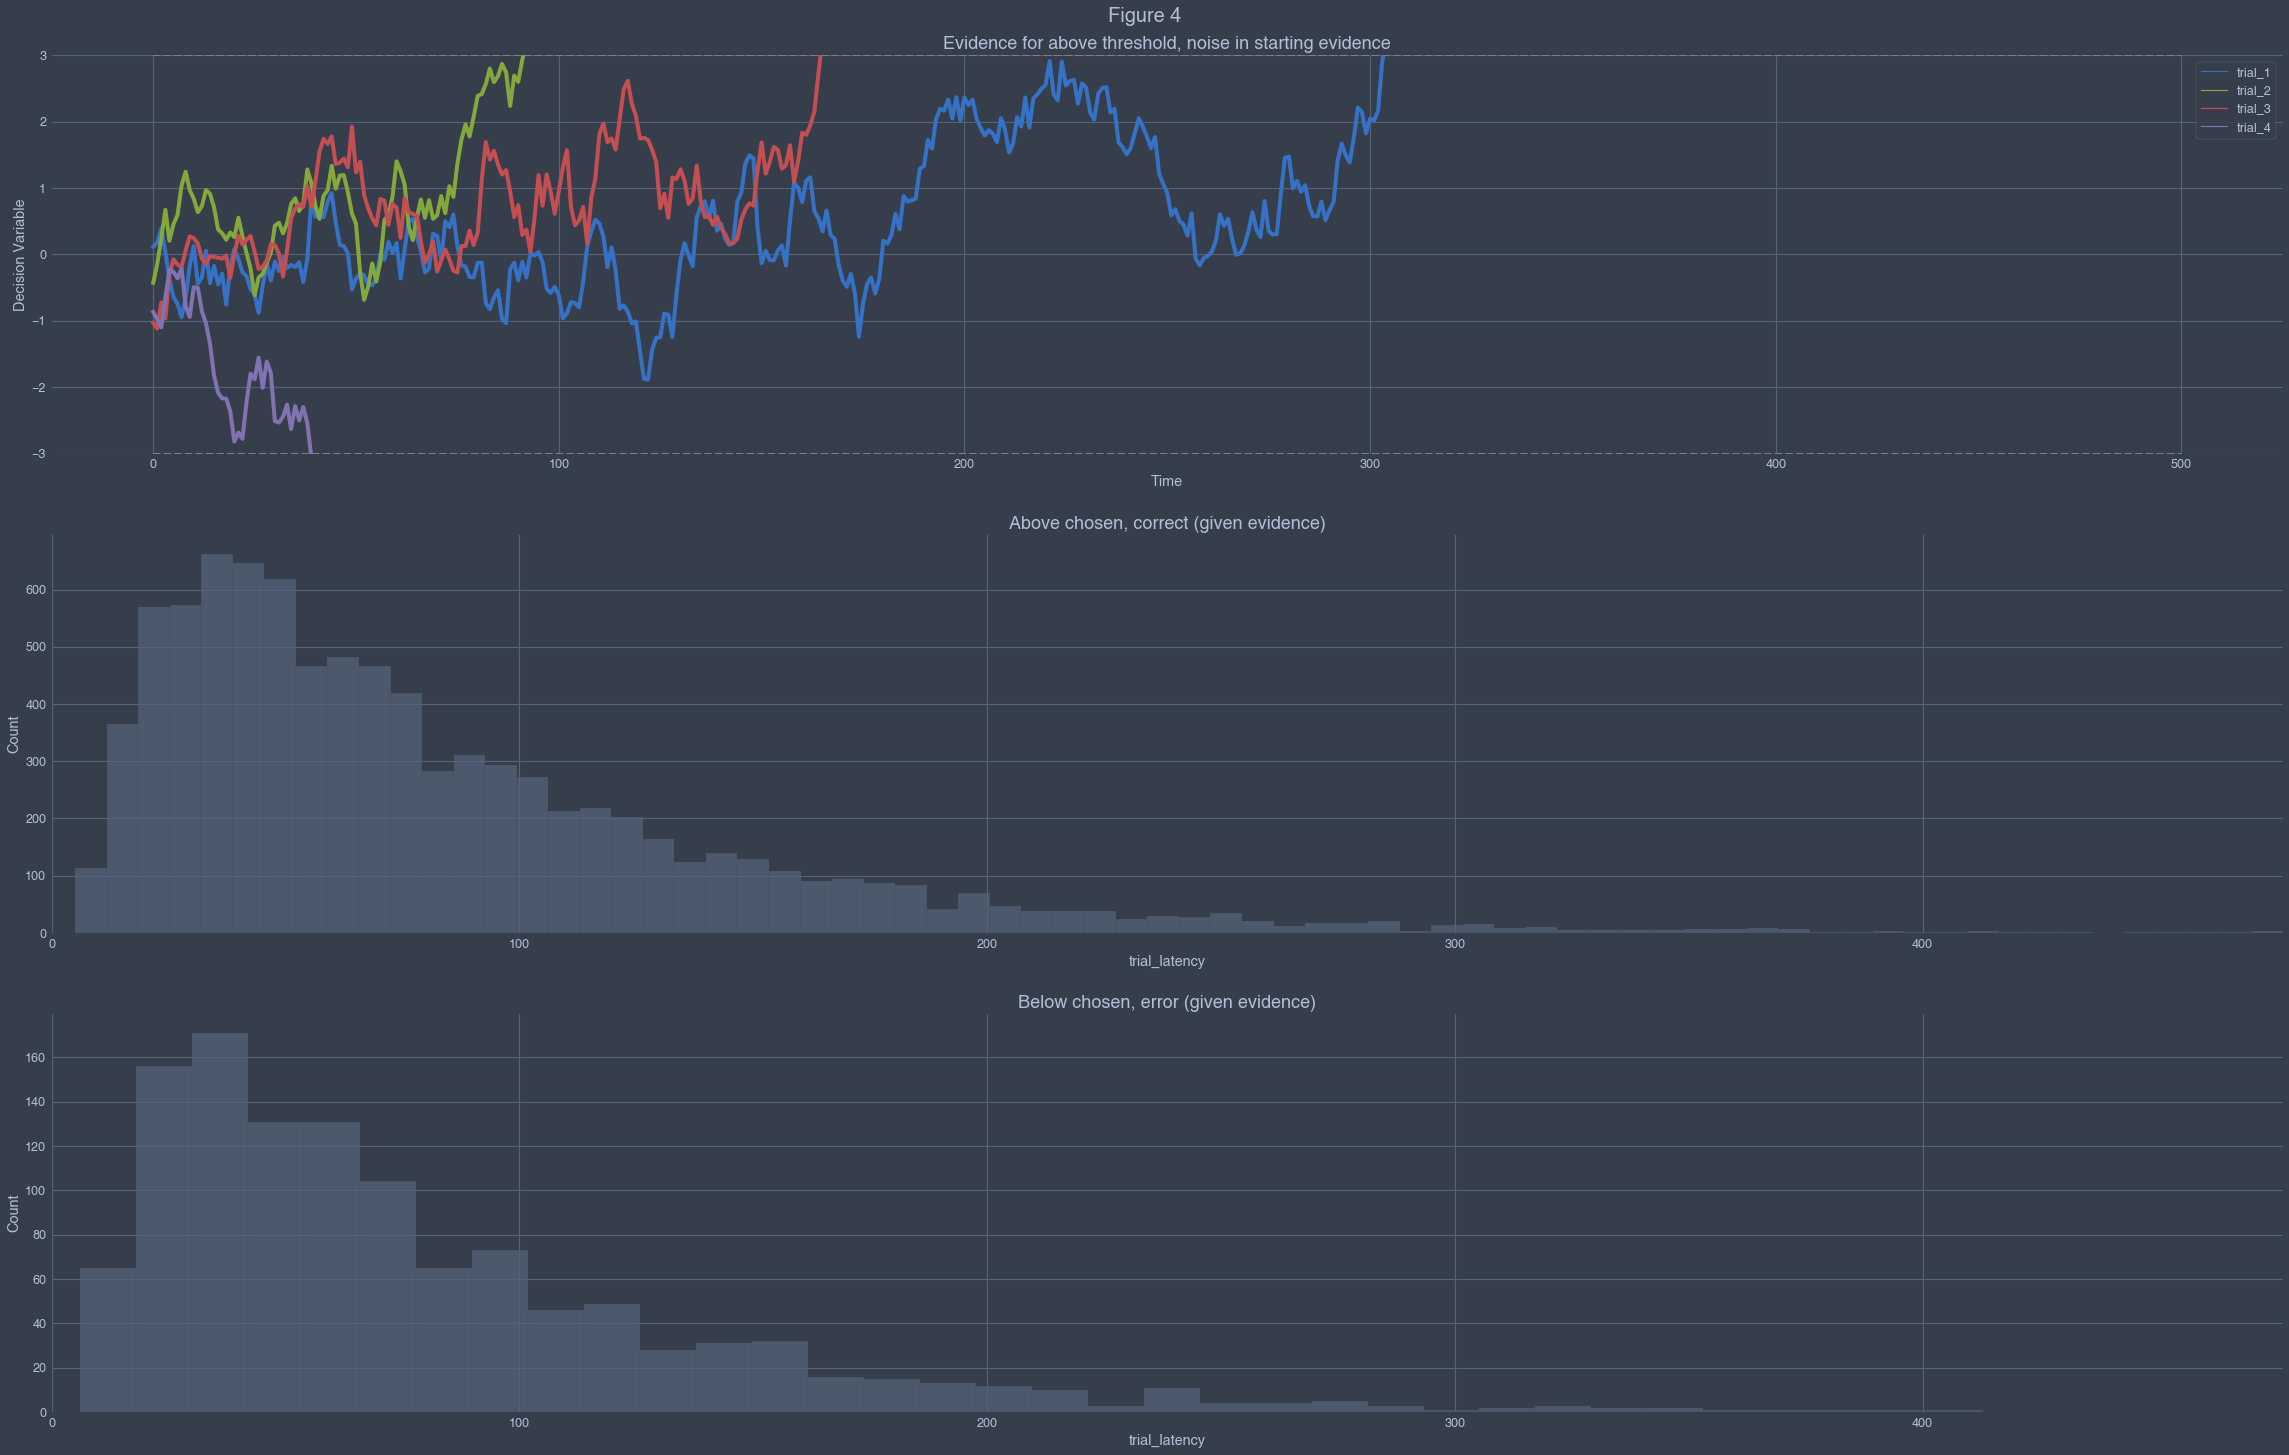

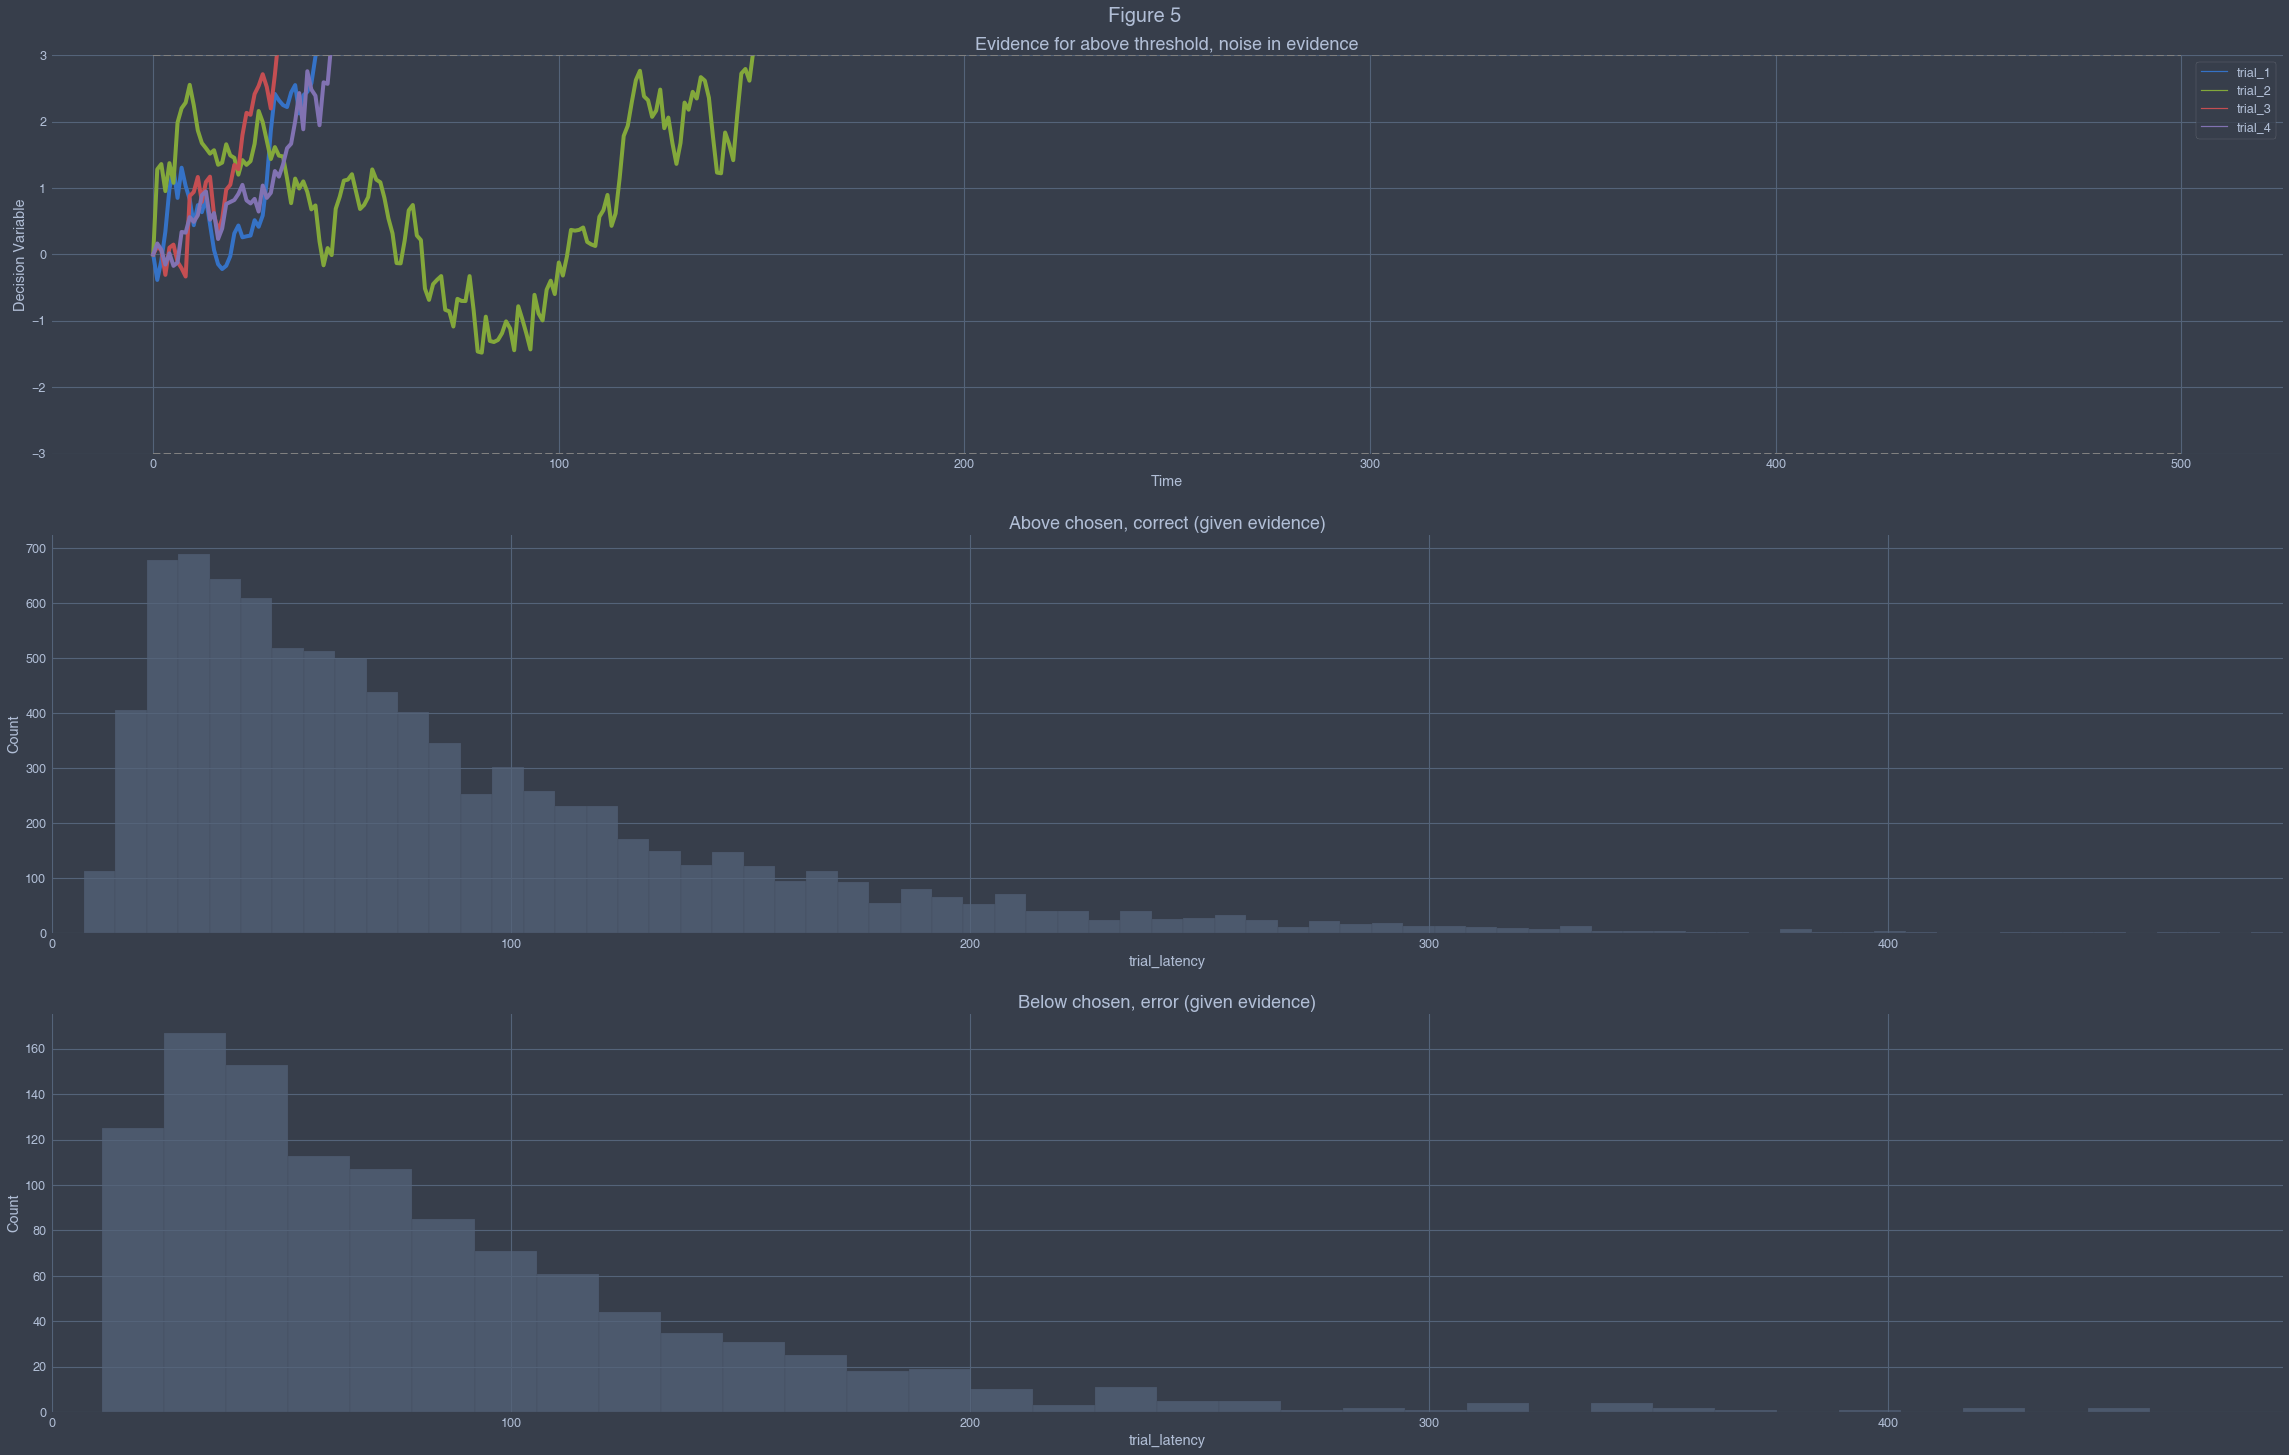

In [10]:
jtplot.style('onedork',
             spines=False,
             figsize=(40, 25))

titles = {'dv': 'Evidence for above threshold, noise in starting evidence',
          'dist_chose_above': 'Above chosen, correct (given evidence)',
          'dist_chose_below': 'Below chosen, error (given evidence)'
          }
plot_random_walk_with_distribution(
    df_dv_above_noisy_start, df_trials_above_noisy_start, titles)


txt = 'Figure 4'
plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=20);

titles = {'dv': 'Evidence for above threshold, noise in evidence',
          'dist_chose_above': 'Above chosen, correct (given evidence)',
          'dist_chose_below': 'Below chosen, error (given evidence)'
          }
plot_random_walk_with_distribution(
    df_dv_above_noisy_evidence, df_trials_above_noisy_evidence, titles);


txt = 'Figure 5'
plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=20);


Noise in the starting evidence (Fig 4): Choices made for the opposite side to evidence are faster in this example, likely due being commonly associated with a starting evidence closer to the boundry.

<br>

Noise in the standard deviation of the evidence (Fig 5) [noise in the drift rate]: Although the proportion of errors is similar to without the noise in the drift rate (see figure 3), the latencies are generally longer. When the Drift rate has a higher value the probability of being correct goes up and of being a faster trial. When the drift rate has a lower value, the probability of being correct goes down and the trial gets slower. In this sense, in the error condition, fast trials are replaced with slow trials, shifting the distribution right.

<br>

Notably, this allows us to achieve both faster and slower errors than corrects. Vary subtle manipulations to the model have large impacts on their predictions.

### 2.2.5 A Family of Possible Sequential-Sampling Models

There are many available options for how to model decision making in a similar way. For example, you could maintain evidence for each option in separate accumulators. You could have time/evidence either continuous or not. A map of such sequential sampling models can be found on figure 2.6 (in the book).

## The Basic Toolkit

### Parameters

Parameter: A value which is set before running a model. They can be used to modify the behaviour of a model and it's predictions without changing the architecture of the model.

(pg 38)